In [60]:
# Import packages and set up
import numpy as np
from matplotlib import pyplot as plt
import rospy
import cv2
from cv_bridge import CvBridge
from sensor_msgs.msg import CompressedImage, Image
import pyrosbag as prb
import jupyros as jr
from ipywidgets import Video
from sklearn.decomposition import PCA
import pandas as pd
from scipy.signal import butter, filtfilt
import sys
if not '/home/ed/sm_ws/install/' in sys.path:
    sys.path.append('/home/ed/sm_ws/install/')
from cv_bridge.boost.cv_bridge_boost import getCvType
import seaborn as sns
%matplotlib inline

In [3]:
# ROS stuff (roscore needs to be running to proceed)
rospy.init_node('eda', anonymous=True)
br = CvBridge()
therm_pub = rospy.Publisher("thermal/camera/processed", Image, queue_size=1)
color_pub = rospy.Publisher("color/camera/processed", Image, queue_size=1)

# Motivation 
The purpose of this project is to build a pipeline to help understand the behavioral patterns of young chickens kept in a backyard coop. The techniques applied here for animal monitoring may be used to improve animal welfare outcomes at commercial farms, which on the one hand have stringent reporting requirements but on the other rely heavily on error-prone and gap-filled manual observation.

# Introduction to the Data Subjects
The data subjects for this experiment are ten young chickens kept in a backyard coop. There are two coops in the backyard: a larger one with two adult hens and a smaller one with ten young chickens. The smaller coop, where the data for this EDA was collected, affords a mounting point for cameras with a visibility of approximately half of the floor area within the coop. The larger coop where the chickens will eventually live affords a much greater visibility as the cameras are mounted higher up. The young chickens are of similar size to each other and have a wide range of plumage colors and patterns. 

On 6/13/2020, a number of scenarios were run:
1. Basic - nominal behavior
2. Feeding time - a more active set of motions after the feeding tray was replenished
3. Bread - a yet more active set of motions after a bread treat was added to the coop
4. High FPS - nominal behavior, but at 30FPS rather than 5FPS for the above

### TODO how big is the dataset?

# Sensor Setup
The sensor setup consists of a Leopard Imaging fisheye color camera (1920x1080 at 30FPS) and FLIR Lepton thermal camera (80x60 at 30FPS). Both cameras were connected to a Jetson Nano and the complete assembly was mounted on the ceiling of a chicken coop pointing downwards. The camera drivers were launched through ROS, and the video streams were saved in a `rosbag` format. This approach assures correct image timestamping. The image rate was throttled to 5FPS and the individual frames were compressed in the `jpeg` format to reduce file size.

Images from the color and thermal camera at a given time in the video stream are presented side by side below at the correct scale relative to each other. It is apparent that both the image resolution and aspect ratios are drastically different between the two frames (color: 1920x1080, AR=1.78; thermal: 80x60, AR=1.33). Therefore, a preprocessing step involves cropping the color image to overlap entirely with the field of view of the thermal camera. The frames are not perfectly synchronized but at this recording rate the difference is about 0.1s, which is negligible compared to the dynamics of the subjects being observed.

# Qualitative Behavior Analysis
In this section we present some examples of typical behaviors, including drinking, eating at the feeding tray,  sitting in a group and flying. Chickens may enter and leave the frame at arbitrary times and be occluded by objects within the cage including a wooden beam and a ladder.

In [12]:
display(Video.from_file('/home/ed/Videos/basic_behaviors.mp4'))

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00fCmoov...')

Intuitively, living objects have a body temperature distinctly above the ambient temperature. The degree to which this may be used to segment animals from their background was not known a priori, but it was clear after reviewing the footage that a simple intensity threshold leading to a binary mask could go a long way to segmenting individual chickens.

In [4]:
blur_window = 3
intensity_threshold = 130 # 150
kernel = np.ones((3,3),np.uint8)

def process_thermal(msg):
    '''
    Convert from ROS to cv2 format
    Apply threshold on image to generate binary mask
    Apply morphological operations to reduce noise
    Calculate contours of binary masks
    '''
    im = br.compressed_imgmsg_to_cv2(msg)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    mean = cv2.mean(im)
    im = cv2.blur(im, (blur_window, blur_window))
    _, thresh = cv2.threshold(im, intensity_threshold, 255, cv2.THRESH_BINARY)
    erode = cv2.erode(thresh,kernel,iterations = 1)    
    dilate = cv2.dilate(erode,kernel,iterations = 1)
    contours = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    return dilate, contours, mean

def process_color(msg):
    '''
    Convert from ROS to cv2 format
    '''
    im = br.compressed_imgmsg_to_cv2(msg)
    return im

Removing previous callback, only one redirection possible right now


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2584e390>]],
      dtype=object)

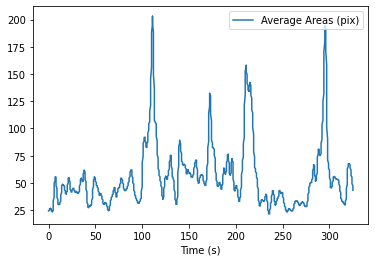

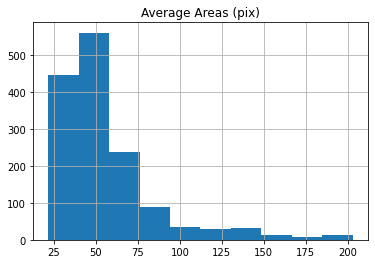

In [19]:
# times = []
# average_areas = []

# def therm_clbk(msg):
#     '''
#     Process received image
#     Calculate properties of blobs
#     '''
#     processed, contours = process_thermal(msg)
#     average_area = 0
#     count = 1;
#     for c in contours:
#         average_area += (cv2.contourArea(c) - average_area)/count;
#         count += 1;        
#     times.append(msg.header.stamp.secs)
#     average_areas.append(average_area)
#     therm_pub.publish(br.cv2_to_imgmsg(processed))
    
# # Listen to thermal image topic and play rosbag    
# jr.subscribe("thermal/camera/image_raw_throttle/compressed", CompressedImage, therm_clbk)
# with prb.BagPlayer("/home/ed/Data/2020-06-13-14-00-00_test/feeding/2020-06-13-14-20-38_0.bag") as example:
#     example.play(publish_rate_multiplier=100.0)
#     while example.is_running:
#         pass 

# # Display filtered result of average blob size    
# df = pandas.DataFrame({'Time (s)': [x - times[0] for x in times], 'Average Areas (pix)': average_areas})
# b, a = butter(2, .1)
# df['Average Areas (pix)'] = filtfilt(b, a, df['Average Areas (pix)'])
# df.plot(x='Time (s)', y='Average Areas (pix)')
# df.hist('Average Areas (pix)')

In [21]:
# Verify the projection of the segmentation from the thermal image onto the color image

color_k = 1
dx = int(410 * color_k)
dy = int(0 * color_k)
wc = 1920 * color_k
hc = 1080 * color_k
wt = 80
ht = 60
wtc = int((1650 * color_k - dx))
scaled_h = ht / wt * (1650-410)
htc = int((scaled_h * color_k - dy))

scale = np.identity(3)
trans = np.identity(3)
scale[0,0] = wtc / wt
scale[1,1] = htc / ht
trans[0,2] = dx
trans[1,2] = dy
T_color_therm = np.dot(trans, scale)

times = []
average_areas = []
contours_therm = None
processed_therm = None
mean_therms = []
occ_hm = np.zeros((ht, wt))

def therm_clbk(msg):
    '''
    Process received image
    Calculate properties of blobs
    '''
    global contours_therm
    global processed_therm
    processed_therm, contours_therm, mean_therm = process_thermal(msg)
    average_area = 0
    count = 1;
    for c in contours_therm:
        average_area += (cv2.contourArea(c) - average_area)/count;
        count += 1;        
    times.append(msg.header.stamp.secs)
    average_areas.append(average_area)
    mean_therms.append(mean_therm[0])
    therm_pub.publish(br.cv2_to_imgmsg(processed_therm))
    
def color_clbk(msg):
    global contours_therm
    global processed_therm
    processed_color = process_color(msg)
    size = processed_color.shape
    mask = np.zeros((size[0], size[1]))
    if contours_therm is not None and processed_therm is not None:
        for c in contours_therm:
            rect = cv2.minAreaRect(c)
            box_t = cv2.boxPoints(rect)
            box_t = np.int0(box_t)
            box_c = []
            center_t = [0,0]
            count = 1
            for p in box_t:
                center_t[0] += (box_t[count-1][0] - center_t[0])/count
                center_t[1] += (box_t[count-1][1] - center_t[1])/count
                p = np.append(p, 1.0) # make homogeneous
                res = np.dot(T_color_therm, p)
                res = [int(x) for x in res]
                box_c.append(res[0:2])
                count += 1
            center_t = np.int0(center_t)
            occ_hm[center_t[1], center_t[0]] += 1
            box_c = np.array(box_c)
            cv2.drawContours(processed_color, [box_c], 0,(0,255,0),5)
        processed_color = cv2.rectangle(processed_color, (dx, dy), (dx + wtc, dy + htc), (255, 255, 0), 5)
        color_pub.publish(br.cv2_to_imgmsg(processed_color, encoding='bgr8'))    

In [31]:
def transform_color_to_therm(img):
    '''Apply crop, translate and resize to color image to make 1:1 correlation with thermal'''
    img = img[dy:dy+htc, dx:dx+wtc]
    img = cv2.resize(img, dsize=(wt, ht), interpolation=cv2.INTER_CUBIC)
    return img

In [28]:
# Listen to topics and play rosbag    
jr.subscribe("thermal/camera/image_raw_throttle/compressed", CompressedImage, therm_clbk)
jr.subscribe("color/camera/image_raw_throttle/compressed", CompressedImage, color_clbk)
with prb.BagPlayer("/home/ed/Data/2020-06-13-14-00-00_test/feeding/2020-06-13-14-20-38_0.bag") as example:
    example.play(publish_rate_multiplier=100.0)
    while example.is_running:
        pass 

Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now


In [65]:
# Make a histogram of the chicken colors based on the overlaid segmentation masks from the thermal camera

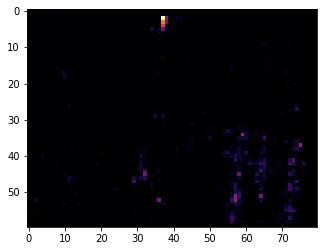

In [134]:
# Heatmap for chicken location
plt.imshow(occ_hm, cmap='inferno')

In [67]:
# When they are close to each other, they appear to merge in the thermal image

The thermal camera periodically undergoes a process known as [Flat Field Correction (FFC)](https://www.flir.com/support-center/oem/what-calibration-terms-are-applied-in-the-camera-there-is-the-ffc-and-also-the-gain-calibration.-are-there-others-can-i-do-my-own-calibration/). At arbitrary intervals, the shutter will move to cover the field of view provide a uniform surface for re-calibration if the camera's temperature fluctuates. After this event, the average pixel intensity across the whole frame increases. It may be possible to apply a low-pass filter over multiple frames to adaptively set the threshold. This phenomenon is clearly observed at the higher recording rate of 30FPS and less frequently at the 5FPS rate. As the online processing will be done at the higher rate, it is necessary to apply this filtering even though the lower rate datasets which will probably be used for development don't display it as clearly.

In [91]:
# Show an example of this phenomenon and plot the change of the average pixel intensity 
with prb.BagPlayer("/home/ed/Data/2020-06-13-14-00-00_test/high_fps/2020-06-13-14-41-09_0.bag") as example:
    example.play(publish_rate_multiplier=50.0, start_time=0)
    while example.is_running:
        pass    

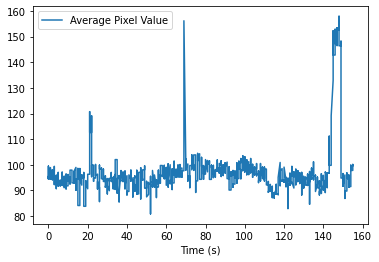

In [93]:
# Display average pixel value per frame
df = pd.DataFrame({'Time (s)': [x - times[0] for x in times], 'Average Pixel Value': mean_therms})
df.plot(x='Time (s)', y='Average Pixel Value')

In [89]:
# PCA of each channel

pca_therm_frame = None
pca_color_frame = None

def therm_clbk(msg):
    '''
    Process received image
    Calculate properties of blobs
    '''
    global pca_therm_frame
    pca_therm_frame = br.compressed_imgmsg_to_cv2(msg)
    
def color_clbk(msg):
    global pca_color_frame
    pca_color_frame = br.compressed_imgmsg_to_cv2(msg)
    pca_color_frame = transform_color_to_therm(pca_color_frame)

jr.subscribe("thermal/camera/image_raw_throttle/compressed", CompressedImage, therm_clbk)
jr.subscribe("color/camera/image_raw_throttle/compressed", CompressedImage, color_clbk)
with prb.BagPlayer("/home/ed/Data/2020-06-24-11-33-00_test/2020-06-24-11-58-51_8.bag") as example:
    example.play(publish_rate_multiplier=1.0, start_time=0, duration=1)
    while example.is_running:
        pass     

Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now


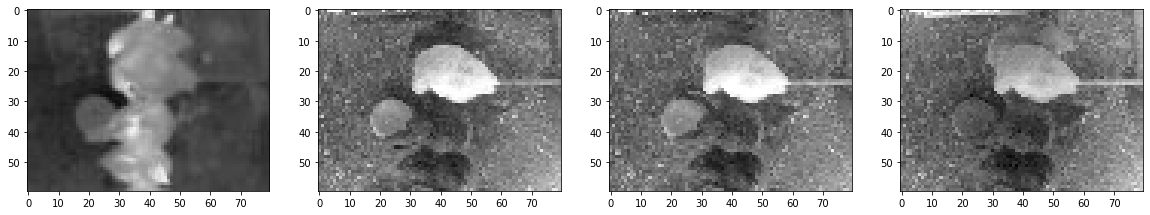

In [90]:
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
pca_therm_frame = pca_therm_frame[:,:,0]
b = pca_color_frame[:,:,0]
g = pca_color_frame[:,:,1]
r = pca_color_frame[:,:,2]
frames = [pca_therm_frame, b, g, r]

for i in range(len(frames)):
    axs[i].imshow(frames[i], cmap='gray', vmin=0, vmax=255)

In [91]:
n_bands = 4
matrix = np.zeros((b.size, n_bands))
for i in range(n_bands):
    arr = frames[i].flatten()
    arr_std = (arr - arr.mean())/arr.std()
    matrix[:,i] = arr_std


In [92]:
np.set_printoptions(precision=3)
cov = np.cov(matrix.transpose())
eigval, eigvec = np.linalg.eig(cov)
print(eigval)
order = eigval.argsort()[::-1]
eigval = eigval[order]
eigvec = eigvec[:,order]
pc = np.matmul(matrix, eigvec)

[2.737 0.997 0.231 0.035]


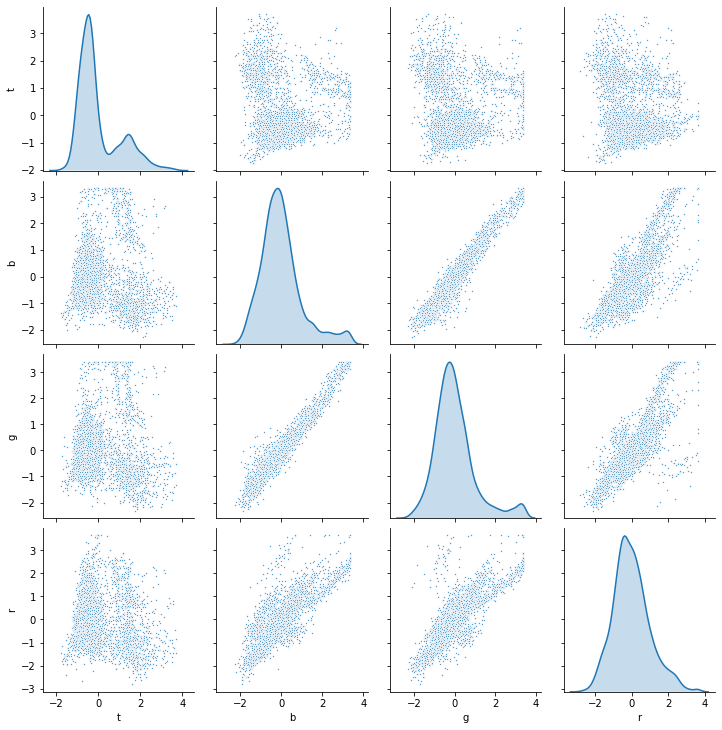

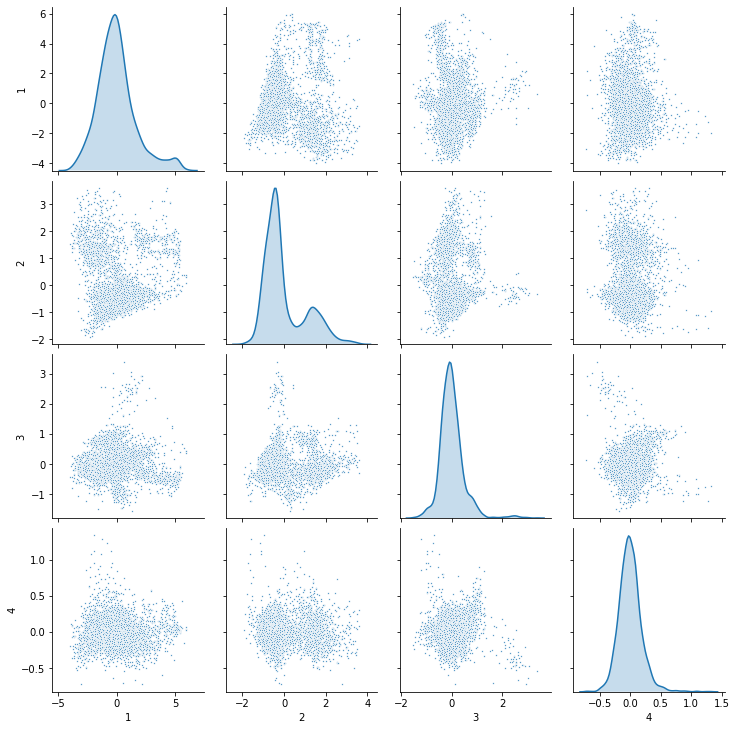

In [93]:
bands = ['t', 'b', 'g', 'r']
pp_orig = sns.pairplot(pd.DataFrame(matrix, columns=bands), diag_kind='kde', plot_kws={"s": 3})
pcs = ['1', '2', '3', '4']
pp_pca = sns.pairplot(pd.DataFrame(pc, columns=pcs), diag_kind='kde', plot_kws={"s": 3})

In [94]:
pc2d = np.zeros((b.shape[0], b.shape[1], n_bands))
for i in range(n_bands):
    pc2d[:, :, i] = pc[:,i].reshape(-1, b.shape[1])
    pc2d[:, :, i] = cv2.normalize(pc2d[:, :, i], np.zeros(b.shape), 0, 255, cv2.NORM_MINMAX)


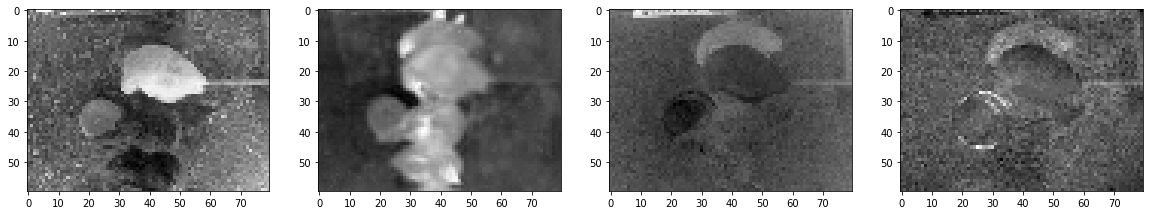

In [95]:
figs, axes = plt.subplots(1, 4, figsize=(20,20))
for i in range(n_bands):
    axes[i].imshow(pc2d[:,:,i], cmap='gray')

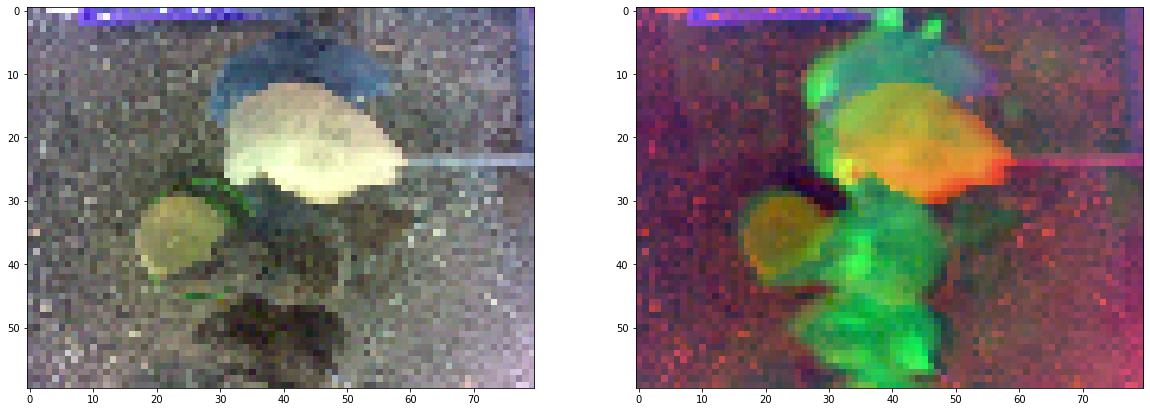

In [96]:
figs, axes = plt.subplots(1, 2, figsize=(20,20))
axes[0].imshow(pca_color_frame.astype(int))
axes[1].imshow(pc2d[:, :, :3].astype(int))

# Questions for Potential Future Exploration
## Experimental Setup
1. How sensitive is the performance of thermal segmentation to the ambient conditions, including temperature and sunlight penetration?
2. Is it possible to use a smaller number of chickens, which are very distinct from each other in appearance, to simplify the tracking task?
3. How can the environment be simplified to maximize the contast of the chickens against the background?

## Image Processing
1. How much could background subtraction improve segmentation performance? Is it a worthwhile preprocessing step?
2. What are the effects of the frame rate on tracking performance?
3. What improvement in tracking performance is available if the full field of the color camera is used, even if thermal data is not available there?
4. How much can the color image be downsampled before performance starts to degrade significantly?

## Modeling
1. What are the implications of using either a frame-aligned bounding box, an oriented bounding box or an ellipse for object detection?

## Behavior Analysis
1. How much has a given chicken eaten, drunk and moved over the course of a day?
2. Is every chicken present?
3. What is the structure of the social groups?

# Defining the Tracking Problem
This task can be cast as a real-time online multi-object detection and tracking problem. 